In [1]:
from settings import *

##### Set global constants for this experiment

In [2]:
delta_t = 0.5
N = 5
L = 100


##### Load observables

In [3]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [4]:
rho0s = random_rho0s(m=m, L=L, seed=34421)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

##### Create a qubit layout and a parametrized circuit on those qubits

In [5]:
qubits = TriangularLayoutA(m=m, distance=0.9)
circuit = HEA_fac(qubits, depth=10, repeats=1)

<Axes: title={'center': 'Qubit layout'}>

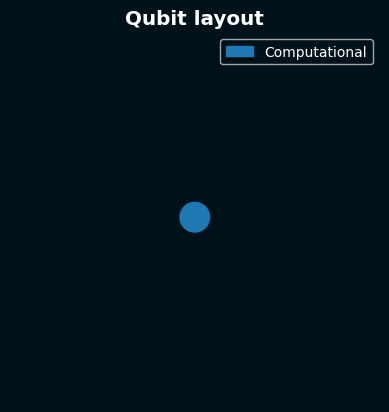

In [6]:
qubits.show_layout()

In [7]:
# optionally load already optimized theta

# theta_opt = np.load("ham_theta_opt.npy")

##### Optimize the parameters

In [8]:
theta_opt, errors, thetas = optimize(
    circuit=circuit,
    training_data=training_data,
    n_grad=10,
    max_count=100,
    # seed=59308
)

# optionally, save the results of the optimization process

theta_opt = np.save("ham_theta_opt.npy", theta_opt)
thetas = np.save("ham_thetas.npy", thetas)
errors = np.save("ham_errors.npy", errors)

optimizer (optimization indices): setting seed=78310


C:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_channel_approx\optimizer.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


small sigma
Zero gradient hit after 46 iterations


In [9]:
theta_opt = np.load("ham_theta_opt.npy")
thetas = np.load("ham_thetas.npy")
errors = np.load("ham_errors.npy")

Text(0, 0.5, 'error')

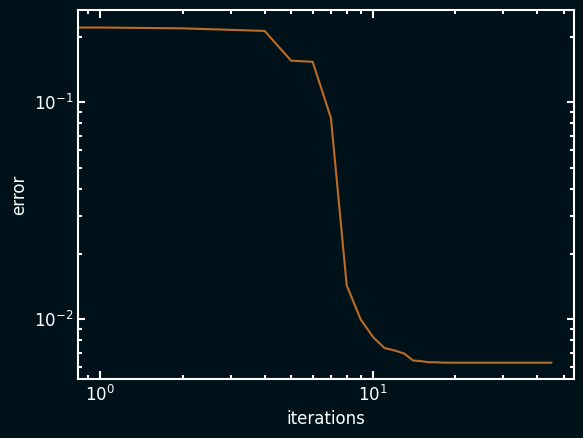

In [10]:
plt.loglog(errors)
plt.xlabel("iterations")
plt.ylabel("error")

##### Compare approximated Hamiltonian to the actual Hamiltonian

In [36]:
eH_approx = -circuit(theta_opt) # with the minus the result is much closer, but why?
H_approx = sc.linalg.logm(eH_approx) / (-1j * delta_t)

H_ref = create_hamiltonian(system).full()
eH_ref = sc.linalg.expm((-1j) * delta_t * H_ref)

In [37]:
eH_approx

array([[ 9.78957644e-01-0.00047525j,  1.29885757e-05-0.20406299j],
       [-1.29885757e-05-0.20406299j,  9.78957644e-01+0.00047525j]])

In [38]:
eH_ref

array([[0.98006658+0.j        , 0.        -0.19866933j],
       [0.        -0.19866933j, 0.98006658+0.j        ]])

In [39]:
H_ref

array([[0. +0.j, 0.4+0.j],
       [0.4+0.j, 0. +0.j]])

In [40]:
H_approx

array([[ 0.00095723-6.80011603e-16j,  0.41101294+2.61609058e-05j],
       [ 0.41101294-2.61609058e-05j, -0.00095723-1.63757896e-15j]])

##### Plot approximated solution compared to reference solution

In [41]:
n_time_steps = 20

rho0 = rho_rand_haar(m=m)

Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

rho_rand_haar: seed=97516


In [42]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(rho0, 
                                delta_t=delta_t, 
                                N=n_time_steps, 
                                s=system, 
                                jump_opers=jump_oper_decay,
                                )
Ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

# calculate approximated solution

evolver = evolver_fac(circuit, theta_opt)
rhos_approx = evolver(n=n_time_steps, rho=rho0.full())
Ess_approx = measure_rhos(rhos_approx, Os_comp)

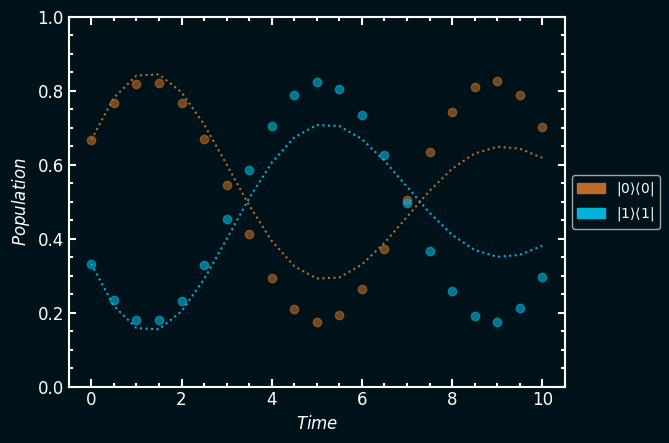

In [43]:
plot_ref(ts, Ess_ref)
plot_approx(ts, Ess_approx)

plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 1)
plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))